# Travel in 2020

The year 2020 has been filled with many different events that have impacted various commercial areas. Specifically, the travel industry in the United States has seen a significant down tick in the number of people traveling. The purpose of this project is to collect data from various different sources to see if we can predict with high accuracy the number of people that would travel on a single day in 2020, specifically flying. We will be using data for number of travelers from the TSA website, data from the ourworldindata.org for covid case counts per day, stock market data from yahoo finance, and various other sources to know dates of travel bans.  

## Import Libraries

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
import math
from bs4 import BeautifulSoup
%matplotlib inline
from dfply import *

## Read in data

In [3]:
#Read in covid case and death count data
covid = pd.read_csv('daily-covid-cases-deaths.csv')

In [4]:
#Check to see if read in properly
covid.head()

,Entity,Code,Date,Daily new confirmed cases of COVID-19,Daily new confirmed deaths due to COVID-19
0,Afghanistan,AFG,2020-01-23,0,0
1,Afghanistan,AFG,2020-01-24,0,0
2,Afghanistan,AFG,2020-01-25,0,0
3,Afghanistan,AFG,2020-01-26,0,0
4,Afghanistan,AFG,2020-01-27,0,0


In [5]:
#Read in stock market data
stock = pd.read_csv('^DJI.csv')

In [6]:
#Check to see if read in properly
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-10,27900.650391,27949.019531,27804.000000,27881.720703,27881.720703,213250000
1,2019-12-11,27867.310547,27925.500000,27801.800781,27911.300781,27911.300781,213510000
2,2019-12-12,27898.339844,28224.949219,27859.869141,28132.050781,28132.050781,277740000
3,2019-12-13,28123.640625,28290.730469,28028.320313,28135.380859,28135.380859,250660000
4,2019-12-16,28191.669922,28337.490234,28191.669922,28235.890625,28235.890625,286770000


In [9]:
#Read in data for number of travelers
tsa_data = pd.read_csv('tsa_data.csv')

In [13]:
#Check to see if read in properly
tsa_data.head()

,Date,Total Traveler Throughput,Total Traveler Throughput (1 Year Ago - Same Weekday)
0,12/9/2020,"564,372","2,020,488"
1,12/8/2020,"501,513","1,897,051"
2,12/7/2020,"703,546","2,226,290"
3,12/6/2020,"837,137","2,292,079"
4,12/5/2020,"629,430","1,755,801"


In [14]:
#Sources for NBA and other sport suspensions
# https://www.nba.com/news/nba-suspend-season-following-wednesdays-games
# https://bleacherreport.com/articles/2880569-timeline-of-coronavirus-impact-on-sports

In [103]:
#Create dataset to show when first major sports league suspended season (NBA) and when it restarted
nba = pd.DataFrame()

sports_maybe = []

for i in range(1, 366):
    if i < 71:
        sports_maybe.append(1)
    elif i >= 71 and i < 189:
        sports_maybe.append(0)
    else:
        sports_maybe.append(1)
        
nba['Games'] = sports_maybe
        

In [104]:
nba.head()

,Games
0,1
1,1
2,1
3,1
4,1


In [105]:
#Source for first mask recommendation made by CDC
# https://www.npr.org/sections/coronavirus-live-updates/2020/04/03/826219824/president-trump-says-cdc-now-recommends-americans-wear-cloth-masks-in-public

In [106]:
#Create dataset to show when masks were recommended

masks = pd.DataFrame()

masks_lst = []

for i in range(1, 366):
    if i < 93:
        masks_lst.append(0)
    else:
        masks_lst.append(1)

masks['recommendation'] = masks_lst

In [107]:
#Check dataset
masks

,recommendation
0,0
1,0
2,0
3,0
4,0
...,...
360,1
361,1
362,1
363,1


## Clean up data and Create main dataframe

In [32]:
#Clean up covid dataset to only include United States
usa_covid = covid.loc[covid['Entity'] == 'United States']

In [34]:
#Check earliest date for tsa dates
tsa_data.tail()

,Date,Total Traveler Throughput,Total Traveler Throughput (1 Year Ago - Same Weekday)
279,3/5/2020,"2,130,015","2,402,692"
280,3/4/2020,"1,877,401","2,143,619"
281,3/3/2020,"1,736,393","1,979,558"
282,3/2/2020,"2,089,641","2,257,920"
283,3/1/2020,"2,280,522","2,301,439"


The earliest date for the flights begin on March 1, 2020. We will need to drop all other observations before that date.

In [52]:
#Drop all dates from stock before March 1
stock = stock[(stock['Date'] >= '2020-03-01') & (stock['Date'] <= '2020-12-09')].reset_index()

In [51]:
#Drop all dates from covid before March 1
usa_covid = usa_covid[(usa_covid['Date'] >= '2020-03-01') & (usa_covid['Date'] <= '2020-12-09')].reset_index()

In [53]:
#Check to see that all worked out
stock.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,55,2020-03-02,25590.509766,26706.169922,25391.960938,26703.320313,26703.320313,637200000
1,56,2020-03-03,26762.470703,27084.589844,25706.279297,25917.410156,25917.410156,647080000
2,57,2020-03-04,26383.679688,27102.339844,26286.310547,27090.859375,27090.859375,457590000
3,58,2020-03-05,26671.919922,26671.919922,25943.330078,26121.279297,26121.279297,477370000
4,59,2020-03-06,25457.210938,25994.380859,25226.619141,25864.779297,25864.779297,599780000


In [54]:
usa_covid.head()

,index,Entity,Code,Date,Daily new confirmed cases of COVID-19,Daily new confirmed deaths due to COVID-19
0,61551,United States,USA,2020-03-01,7,0
1,61552,United States,USA,2020-03-02,23,5
2,61553,United States,USA,2020-03-03,19,1
3,61554,United States,USA,2020-03-04,33,4
4,61555,United States,USA,2020-03-05,77,1


In [56]:
#Drop the index columns
stock.drop(labels = 'index', axis = 1, inplace = True)
usa_covid.drop(labels = 'index', axis = 1, inplace = True)

In [57]:
#Check to see it worked
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-03-02,25590.509766,26706.169922,25391.960938,26703.320313,26703.320313,637200000
1,2020-03-03,26762.470703,27084.589844,25706.279297,25917.410156,25917.410156,647080000
2,2020-03-04,26383.679688,27102.339844,26286.310547,27090.859375,27090.859375,457590000
3,2020-03-05,26671.919922,26671.919922,25943.330078,26121.279297,26121.279297,477370000
4,2020-03-06,25457.210938,25994.380859,25226.619141,25864.779297,25864.779297,599780000


In [60]:
usa_covid.head()

,Entity,Code,Date,Daily new confirmed cases of COVID-19,Daily new confirmed deaths due to COVID-19
0,United States,USA,2020-03-01,7,0
1,United States,USA,2020-03-02,23,5
2,United States,USA,2020-03-03,19,1
3,United States,USA,2020-03-04,33,4
4,United States,USA,2020-03-05,77,1


In [62]:
len(usa_covid)

284

In [63]:
len(stock)

198

In [96]:
#Attempt to merge covid and stock
main_df = usa_covid.merge(stock, how = 'left', left_on = 'Date', right_on = 'Date')

In [108]:
#Change the NBA dataframe and Mask dataframe to match the dates

nba = nba.iloc[60 : 344]
masks = masks.iloc[60 : 344]

In [109]:
nba = nba.reset_index(drop = True)

In [110]:
masks = masks.reset_index(drop = True)

In [114]:
#Add masks and nba to the main dataframe
main_df['Sports'] = nba['Games']
main_df['Masks'] = masks['recommendation']

In [115]:
#Check to see if it's all there
main_df.head()

,Entity,Code,Date,Daily new confirmed cases of COVID-19,Daily new confirmed deaths due to COVID-19,Open,High,Low,Close,Adj Close,Volume,Sports,Masks
0,United States,USA,2020-03-01,7,0,NaN,NaN,NaN,NaN,NaN,NaN,1,0
1,United States,USA,2020-03-02,23,5,25590.509766,26706.169922,25391.960938,26703.320313,26703.320313,637200000.0,1,0
2,United States,USA,2020-03-03,19,1,26762.470703,27084.589844,25706.279297,25917.410156,25917.410156,647080000.0,1,0
3,United States,USA,2020-03-04,33,4,26383.679688,27102.339844,26286.310547,27090.859375,27090.859375,457590000.0,1,0
4,United States,USA,2020-03-05,77,1,26671.919922,26671.919922,25943.330078,26121.279297,26121.279297,477370000.0,1,0


In [116]:
#Drop entity and code
main_df.drop(labels = ['Entity', 'Code'], axis = 1, inplace = True)

In [122]:
main_df.rename({'Daily new confirmed cases of COVID-19' : 'Cases', 'Daily new confirmed deaths due to COVID-19' : 'Deaths'}, axis = 1, inplace = True)

In [124]:
#Replace NANs 
main_df.fillna({'Open' : main_df['Open'].median(), 
               'High' : main_df['High'].median(),
               'Low' : main_df['Low'].median(), 
               'Close' : main_df['Close'].median(),
               'Adj Close' : main_df['Adj Close'].median(),
               'Volume' : main_df['Volume'].median()}, inplace = True)

In [128]:
#Check it out
main_df.isna().sum()

Date         0
Cases        0
Deaths       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Sports       0
Masks        0
dtype: int64

In [139]:
#Finally add the tsa dataframe
main_df['Travelers 2020'] = tsa_data['Total Traveler Throughput']
main_df['Travelers 2019'] = tsa_data['Total Traveler Throughput (1 Year Ago - Same Weekday)']

In [140]:
#Look at final product?
main_df

,Date,Cases,Deaths,Open,High,Low,Close,Adj Close,Volume,Sports,Masks,Travelers 2020,Travelers 2019
0,2020-03-01,7,0,26668.264649,26855.940429,26500.794922,26668.174805,26668.174805,401285000.0,1,0,"564,372","2,020,488"
1,2020-03-02,23,5,25590.509766,26706.169922,25391.960938,26703.320313,26703.320313,637200000.0,1,0,"501,513","1,897,051"
2,2020-03-03,19,1,26762.470703,27084.589844,25706.279297,25917.410156,25917.410156,647080000.0,1,0,"703,546","2,226,290"
3,2020-03-04,33,4,26383.679688,27102.339844,26286.310547,27090.859375,27090.859375,457590000.0,1,0,"837,137","2,292,079"
4,2020-03-05,77,1,26671.919922,26671.919922,25943.330078,26121.279297,26121.279297,477370000.0,1,0,"629,430","1,755,801"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,2020-12-05,213881,2254,26668.264649,26855.940429,26500.794922,26668.174805,26668.174805,401285000.0,1,1,"2,130,015","2,402,692"
280,2020-12-06,175664,1113,26668.264649,26855.940429,26500.794922,26668.174805,26668.174805,401285000.0,1,1,"1,877,401","2,143,619"
281,2020-12-07,192435,1404,30233.029297,30233.029297,29967.220703,30069.789063,30069.789063,365810000.0,1,1,"1,736,393","1,979,558"
282,2020-12-08,215878,2546,29997.949219,30246.220703,29972.070313,30173.880859,30173.880859,311190000.0,1,1,"2,089,641","2,257,920"


Our dataframe is all prepared and ready to do some EDA.

## EDA

In [141]:
#Look at summary statistics
main_df.describe()

,Cases,Deaths,Open,High,Low,Close,Adj Close,Volume,Sports,Masks
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,2.840000e+02,284.000000,284.000000
mean,54177.947183,1018.915493,26390.153733,26619.178649,26157.870468,26392.210869,26392.210869,4.298291e+08,0.584507,0.887324
std,48470.687826,649.333891,2063.128829,1986.881384,2152.148505,2064.710643,2064.710643,1.117051e+08,0.493677,0.316755
min,7.000000,0.000000,19028.359375,19121.009766,18213.650391,18591.929688,18591.929688,1.770400e+08,0.000000,0.000000
25%,25213.500000,537.250000,25900.005859,26102.789551,25609.060058,25855.424317,25855.424317,3.733825e+08,0.000000,1.000000
50%,40737.000000,940.500000,26668.264649,26855.940429,26500.794922,26668.174805,26668.174805,4.012850e+08,1.000000,1.000000
75%,61185.250000,1295.500000,27542.353027,27810.099610,27447.347656,27602.400391,27602.400391,4.402475e+08,1.000000,1.000000
max,227828.000000,3124.000000,30233.029297,30319.699219,29989.560547,30218.259766,30218.259766,9.082600e+08,1.000000,1.000000


In [158]:
#Change Travelers data type
for i in range(0, len(main_df)):
    main_df['Travelers 2020'][i] = main_df['Travelers 2020'][i].replace(',', '')
    main_df['Travelers 2019'][i] = main_df['Travelers 2019'][i].replace(',', '')

C:\Users\thebs\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\thebs\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [164]:
main_df['Travelers 2020'] = pd.to_numeric(main_df['Travelers 2020'])
main_df['Travelers 2019'] = pd.to_numeric(main_df['Travelers 2019'])

In [168]:
#All summary statistics
main_df.describe()

,Cases,Deaths,Open,High,Low,Close,Adj Close,Volume,Sports,Masks,Travelers 2020,Travelers 2019
count,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,2.840000e+02,284.000000,284.000000,2.840000e+02,2.840000e+02
mean,54177.947183,1018.915493,26390.153733,26619.178649,26157.870468,26392.210869,26392.210869,4.298291e+08,0.584507,0.887324,6.383851e+05,2.375686e+06
std,48470.687826,649.333891,2063.128829,1986.881384,2152.148505,2064.710643,2064.710643,1.117051e+08,0.493677,0.316755,4.012484e+05,2.461785e+05
min,7.000000,0.000000,19028.359375,19121.009766,18213.650391,18591.929688,18591.929688,1.770400e+08,0.000000,0.000000,8.753400e+04,1.591158e+06
25%,25213.500000,537.250000,25900.005859,26102.789551,25609.060058,25855.424317,25855.424317,3.733825e+08,0.000000,1.000000,3.466970e+05,2.193565e+06
50%,40737.000000,940.500000,26668.264649,26855.940429,26500.794922,26668.174805,26668.174805,4.012850e+08,1.000000,1.000000,6.339280e+05,2.430741e+06
75%,61185.250000,1295.500000,27542.353027,27810.099610,27447.347656,27602.400391,27602.400391,4.402475e+08,1.000000,1.000000,7.982395e+05,2.556494e+06
max,227828.000000,3124.000000,30233.029297,30319.699219,29989.560547,30218.259766,30218.259766,9.082600e+08,1.000000,1.000000,2.280522e+06,2.882915e+06


In [169]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')

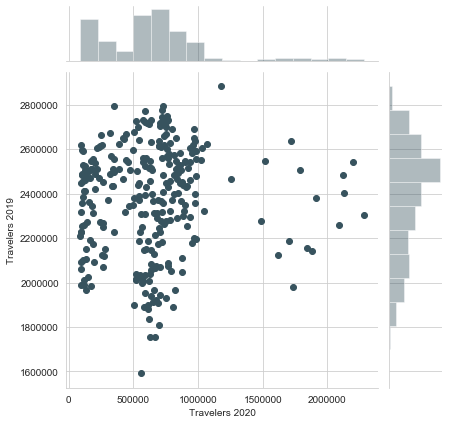

In [177]:
#Graph travel numbers from this year and last year
sns.jointplot(x = 'Travelers 2020', y = 'Travelers 2019', data = main_df)

As we can clearly see, the numbers for 2020 have been significantly smaller than from 2019

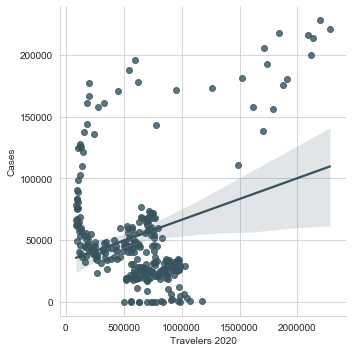

In [194]:
#Graph travelers 2020 vs cases
sns.lmplot(x = 'Travelers 2020', y = 'Cases', data = main_df)

Very interesting shape to this...  

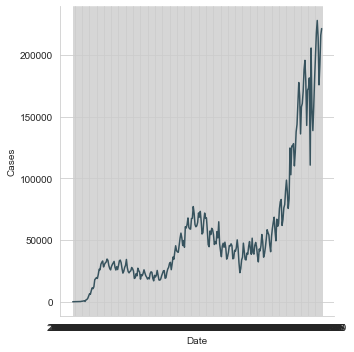

In [171]:
#Plot line graph of number of cases
sns.relplot(x = 'Date', y = 'Cases', kind = 'line', data = main_df)

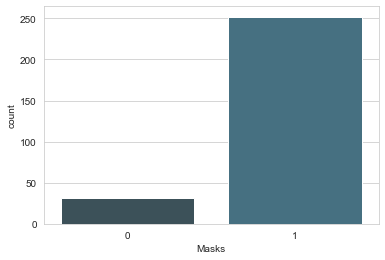

In [172]:
#Plot count of days with masks vs no masks
sns.countplot(x = 'Masks', data = main_df)

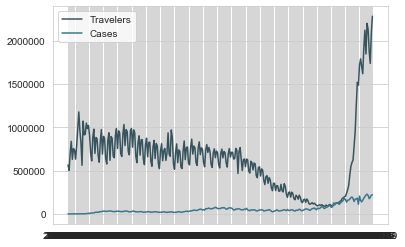

In [174]:
#Plot number of travelers vs number of cases
plt.plot('Date', 'Travelers 2020', data = main_df, label = 'Travelers')
plt.plot('Date', 'Cases', data = main_df, label = 'Cases')

plt.legend()

## Linear Regression

In [203]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

In [184]:
#Separate response from explanatory
y = main_df['Travelers 2020']

X = main_df[['Cases', 'Deaths', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Sports', 'Masks', 'Travelers 2019']]

In [185]:
#Separate training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [186]:
lm = LinearRegression()

In [187]:
#Fit a linear regression model
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [188]:
#Show coefficients
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [ 4.34770099e+00  1.83464093e+02  1.17004012e+02 -1.82928386e+02
  6.75991449e+01 -3.32849264e+00 -3.32849263e+00  5.09455846e-05
 -3.70770896e+05 -5.31593389e+05  2.44579269e-01]


In [189]:
#Gather predictions from fitted model
predictions = lm.predict(X_test)

Text(0, 0.5, 'Predicted Y')

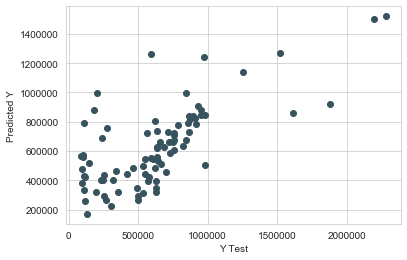

In [190]:
#Plot predictions vs actual
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [200]:
#Generate metrics
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R^2: ', metrics.r2_score(y_test, predictions))

MAE: 209582.34029446437
MSE: 89312463686.86139
RMSE: 298851.9092909754
R^2:  0.5075655165151798


In [204]:
#CV score
print('Cross validation score: ',-1 * ((cross_val_score(lm, X, y, cv=10, scoring='neg_mean_squared_error')).mean()))

Cross validation score:  279372589873.1498


With a RMSE of 298851 and CV score of 279372589873.1498, I would say that this model isn't the best for predicting the number of airplane travelers in 2020, but 2020 has been hard for anyone to predict so it's not the worst thing to come from 2020.

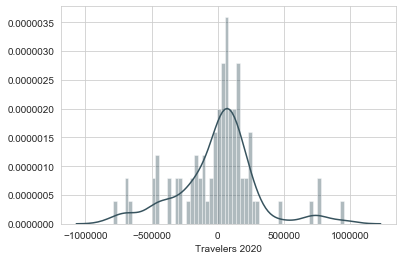

In [192]:
#Plot residuals
sns.distplot((y_test-predictions),bins=60);

At least the residuals look normal? That's good? Our data really isn't that linear though, so linear regression assumptions are iffy on this data

## KNN

In [196]:
from sklearn.neighbors import KNeighborsRegressor

In [197]:
#KNN with 5
knn = KNeighborsRegressor(n_neighbors=5)

In [198]:
#Fit the model
knn.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [199]:
#Make predictions
knn_preds = knn.predict(X_test)

In [205]:
#Get metrics
print('MAE:', metrics.mean_absolute_error(y_test, knn_preds))
print('MSE:', metrics.mean_squared_error(y_test, knn_preds))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, knn_preds)))

MAE: 266025.37674418604
MSE: 144210169285.94885
RMSE: 379750.1406003016


In [206]:
#Get CV score
print('Cross validation score: ',-1 * ((cross_val_score(knn, X, y, cv=10, scoring='neg_mean_squared_error')).mean()))

Cross validation score:  230145124472.75333


Well, this model did not do any better at predicting with accuracy the 